[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmineDiro/OT-GAN/blob/main/OT%20project.ipynb#scrollTo=66I2N56tuMq9)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm.auto import tqdm

#import ot
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Parametres

batch_size=5 # selon les auteurs mais on va pas utiliser ça
ginput_dim = 100
val_batch_size=128
n_epochs=2
lr=3e-4
beta1= 0.5
beta2=0.999
epsilon=1
n_gen=3 #nupmber of generator updates / discriminator update


In [6]:
use_cuda =True
# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [8]:

transform = transforms.Compose([transforms.Grayscale(3) ,transforms.Resize(size=(32, 32)), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data_mnist', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

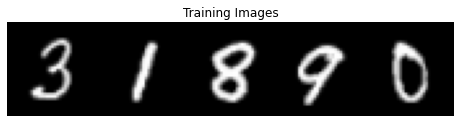

In [11]:
# Plot the training images.
sample_batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## GAN Archiecture

In [12]:
from Generator import Generator
from Discriminator import Discriminator 
from utils import *

In [13]:
gmodel = Generator().to(device)
print(gmodel)

Generator(
  (linear): Linear(in_features=100, out_features=32768, bias=True)
  (conv1): Conv2d(1024, 1024, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (last_conv): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [14]:
# Create the discriminator.
dmodel = Discriminator().to(device)
print(dmodel)

Discriminator(
  (relu): ReLU()
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(1024, 2048, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
)


## Testing loss

In [17]:
noise = ((torch.rand([batch_size, ginput_dim])*-2)+1).to(device)
prime_noise = ((torch.rand([batch_size, ginput_dim])*-2)+1).to(device)
Y = dmodel(gmodel(noise))
Yprime = dmodel(gmodel(prime_noise))

In [19]:
#real data in X
sample1 , _ = next(iter(trainloader))
sample2 , _ = next(iter(trainloader))

X = dmodel(sample1.to(device))
Xprime = dmodel(sample2.to(device))

In [21]:
loss, loss_generator, loss_critic =loss_cos_dist(X, Xprime, Y, Yprime)

tensor(0.6038, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5920, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.6000, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.5849, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.7178, device='cuda:0', grad_fn=<SumBackward1>)
tensor(0.6794, device='cuda:0', grad_fn=<SumBackward1>)


##  Training

In [ ]:
real_label = 1
fake_label = 0

# Store generated images 
img_list = []

# Store losses  training.
G_losses = []
D_losses = []

fiXed_noise = ((torch.rand([batch_size, ginput_dim])*-2)+1).to(device)

for epoch in range(n_epochs):
    # small loop 
    for i, data in enumerate(trainloader):
        if i >10 :
            break
        real_data = data[0].to(device)
        # Get batch size. Can be different from params['nbsize'] for last batch in epoch.
        b_size = real_data.size(0)
        dmodel.zero_grad()      
        
        # Create labels for the real data
        label = torch.full((b_size, ), real_label, device=device)
        output = dmodel(real_data).view(-1)
        print(output.size())
        print(label.size())
        dloss_real = criterion(output, label)
        
        # Calculate gradients for backpropagation.
        dloss_real.backward()
        D_X = output.mean().item()
        
        # Sample random data from a unit normal distribution.
        noise = (torch.rand([batch_size, ginput_dim], requires_grad = True)*-2)+1
        noise = noise.to(device)
        # Generate fake data (images).
        fake_data = gmodel(noise)
        # Create labels for fake data. (label=0)
        label.fill_(fake_label)
        
        # Calculate the output of the discriminator of the fake data.
        # As no gradients w.r.t. the generator parameters are to be
        # calculated, detach() is used. Hence, onlY gradients w.r.t. the
        # discriminator parameters will be calculated.
        # This is done because the loss functions for the discriminator
        # and the generator are slightlY different.
        output = dmodel(fake_data.detach()).view(-1)
        dloss_fake = criterion(output, label)
        # Calculate gradients for backpropagation.
        dloss_fake.backward()
        # Get output means
        D_G_z1 = output.mean().item()

        # Net discriminator loss.
        errD = dloss_real + dloss_fake
        # Update discriminator parameters.
        optimizerD.step()
        
        # Zero grad generator
        gmodel.zero_grad()
        # We want the fake data to be classified as real. Hence
        # real_label are used. (label=1)
        label.fill_(real_label)
        # No detach() is used here as we want to calculate the gradients w.r.t.
        # the generator this time.
        output = dmodel(fake_data).view(-1)
        errG = criterion(output, label)
        # Gradients for backpropagation are calculated.
        # Gradients w.r.t. both the generator and the discriminator
        # parameters are calculated, however, the generator's optimizer
        # will onlY update the parameters of the generator. The discriminator
        # gradients will be set to zero in the neXt iteration bY dmodel.zero_grad()
        errG.backward()

        D_G_z2 = output.mean().item()
        # Update generator parameters.
        optimizerG.step()

        # Check progress of training.
        if i%50 == 0:
            print(torch.cuda.is_available())
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(X): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, params['nepochs'], i, len(dataloader),
                     errD.item(), errG.item(), D_X, D_G_z1, D_G_z2))

        # Save the losses for plotting.
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing bY saving G's output on a fiXed noise.
        #if (iters % 100 == 0) or ((epoch == n_epochs- 1) and (i == len(dataloader)-1)):
        #    with torch.no_grad():
        #        fake_data = gmodel(fiXed_noise).detach().cpu()
        #    # Append to image list
        #    img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))
        #iters += 1

    # Save the model.
    #if epoch % params['save_epoch'] == 0:
    #    torch.save({
    #        'generator' : gmodel.state_dict(),
    #        'discriminator' : dmodel.state_dict(),
    #        'optimizerG' : optimizerG.state_dict(),
    #        'optimizerD' : optimizerD.state_dict(),
    #        'params' : params
    #        }, 'model/model_epoch_{}.pth'.format(epoch))

In [ ]:
K×K matriXM of soft matchings between these i, j elements